#### Goal of this study is to compile a regressor model to understand the most significant features contributing to the prediction of household electricity consumption

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np



nsm = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/non_smart_meter/monthly_consumption.csv')
wave_1_houseinfo = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')
nsm['consumption'] = pd.to_numeric(nsm['consumption'], errors='coerce')
nsm['month'] = pd.to_datetime(nsm['month'])
nsm['month_of_the_year'] = nsm['month'].dt.month
nsm = nsm.sort_values(['household_ID', 'month'])
nsm = nsm.dropna()

#### What Electricity Providers can currently do: 
### 1. Load Forecasting as a time-series problem

In [5]:
# adding lags and rolling statistics
nsm_ts = nsm.copy()

nsm_ts['lag_1'] = nsm_ts.groupby('household_ID')['consumption'].shift(1)
nsm_ts['rolling_3'] = nsm_ts.groupby('household_ID')['consumption'].shift(1).rolling(3).mean().reset_index(0, drop=True)
nsm_ts = nsm_ts.dropna()

In [6]:
# splitting last three months as test set
train = nsm_ts[nsm_ts['month'] < '2024-08-31']
test = nsm_ts[nsm_ts['month'] >= '2024-08-31']

features = ['lag_1', 'rolling_3', 'month_of_the_year']
target = 'consumption'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [7]:
def evaluate(y_true, y_pred, model_name):
    print(f"\n📊 {model_name}")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred):.2f}")   # to Penalizes larger errors more heavily due to squaring.
    print(f"R²:   {r2_score(y_true, y_pred):.3f}")

evaluate(y_test, y_pred, 'Time-series-model')


📊 Time-series-model
MAE:  24.00
RMSE: 3168.24
R²:   0.810


### 2. Household located Area: as an additional layer of information the electricity provider knows

In [8]:
nsm_ts_csc = nsm.merge(wave_1_houseinfo[['household_ID', 'electricity_provider_csc_area']], on= 'household_ID', how= 'left')
nsm_ts_csc['lag_1'] = nsm_ts_csc.groupby('household_ID')['consumption'].shift(1)
nsm_ts_csc['rolling_3'] = nsm_ts_csc.groupby('household_ID')['consumption'].shift(1).rolling(3).mean().reset_index(0, drop=True)
nsm_ts_csc = nsm_ts_csc.dropna()
le = LabelEncoder()
nsm_ts_csc['electricity_provider_csc_area'] = le.fit_transform(nsm_ts_csc['electricity_provider_csc_area'].astype(str))


# splitting last three months as test set
train = nsm_ts_csc[nsm_ts_csc['month'] < '2024-08-31']
test = nsm_ts_csc[nsm_ts_csc['month'] >= '2024-08-31']

features = ['lag_1', 'rolling_3', 'month_of_the_year', 'electricity_provider_csc_area']
target = 'consumption'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

evaluate(y_test, y_pred, 'Time-series-model')


📊 Time-series-model
MAE:  20.99
RMSE: 2268.78
R²:   0.865


### 3. With Easy-to-Collect Features

In [9]:
data_easy = nsm.merge(wave_1_houseinfo, on= 'household_ID', how= 'left')
data_easy = data_easy[['household_ID', 'consumption', 'month_of_the_year','no_of_electricity_meters',
       'electricity_provider_csc_area', 'own_the_house_or_living_on_rent',
       'occupy_renters_boarders',
       'built_year_of_the_house', 'type_of_house',
       'no_of_storeys', 'no_of_household_members',
       'is_there_business_carried_out_in_the_household',
       'whom_or_how_the_house_was_designed',
       'availability_of_certificate_of_compliance',
       'main_material_used_for_walls_of_the_house',
       'main_material_used_for_roof_of_the_house',
       'any_constructions_or_renovations_in_the_household',
       'highest_level_of_education_of_the_chief_wage_earner',
       'occupation_of_the_chief_wage_earner', 'socio_economic_class',
       'total_monthly_expenditure_of_last_month', 'type_of_electricity_meter']].copy()

In [10]:
df_encoded = data_easy.copy()

for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)
data_easy = pd.DataFrame(scaled_data, columns=df_encoded.columns)
data_easy.dropna(inplace=True)

In [11]:
X = data_easy.drop(columns=['household_ID', 'consumption'])
y = data_easy['consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

tree = DecisionTreeRegressor(max_depth=10, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
evaluate(y_test, y_pred_tree, "Decision Tree Regressor")

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate(y_test, y_pred_rf, "Random Forest Regressor")

xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
evaluate(y_test, y_pred_xgb, "XGBoost Regressor")


📊 Decision Tree Regressor
MAE:  0.34
RMSE: 0.53
R²:   0.762

📊 Random Forest Regressor
MAE:  0.31
RMSE: 0.45
R²:   0.796

📊 XGBoost Regressor
MAE:  0.29
RMSE: 0.41
R²:   0.818


#### Feature importance

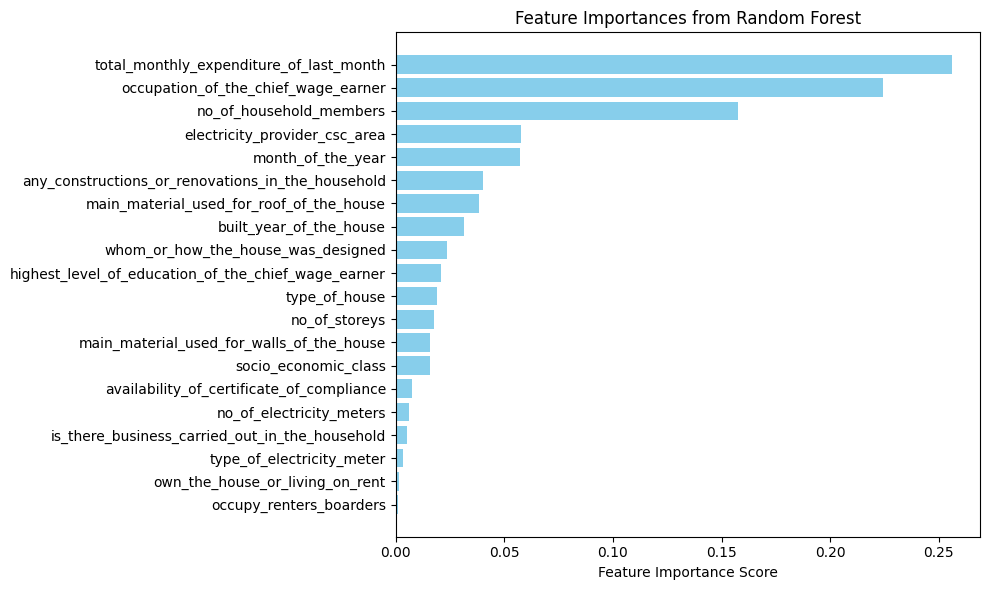

In [12]:
model = rf

importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(features[indices], importances[indices], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

### 4. Features from an Extensive Survey

##### AC usage behaviour 

In [13]:
ac = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_ac_roster.csv')
hours = ac.groupby('household_ID')[['no_of_hours_ac_was_on_during_daytime_last_week', 'no_of_hours_ac_was_on_during_night_last_week']].sum()
ac_hours = pd.DataFrame(hours)
ac_hours

,no_of_hours_ac_was_on_during_daytime_last_week,no_of_hours_ac_was_on_during_night_last_week
household_ID,,
ID0012,0.0,45.0
ID0014,0.0,0.0
ID0018,0.0,56.0
ID0025,0.0,0.0
ID0039,24.0,24.0
...,...,...
ID3950,0.0,2.0
ID4015,0.0,0.0
ID4026,0.0,2.0


##### Weighting Appliances used in households

In [14]:
app = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_appliances.csv')

appliance_weights = {
    # Essential Appliances (Weight = 1)
    "Refrigerator": 1,
    "Microwave": 1,
    "Rice cooker": 1,
    "Electric Iron including electric steam iron": 1,
    "Mobile phone - Basic phones": 1,
    "Mobile phone - Smart phones": 1,
    "Mobile phone - Feature phones": 1,
    "Fixed phones": 1,
    "Emergency Light / re-chargeable torches": 1,

    # Convenience Appliances (Weight = 2)
    "Electric pressure cooker": 2, 
    "Electric Bell" : 2,
    "Separate Freezer": 2,
    "Mini Bar": 2,
    "Electric cook tops (induction cookers, Infra-red cookers, hot plates)": 2,
    "Electric Blender": 2,
    "Electric grinder": 2,
    "Electric mixer / beater": 2,
    "Electric food processor": 2,
    "Electric Kettle": 2,
    "Toaster / Sandwich toaster": 2,
    "Electric coconut scraper": 2,
    "Washing Machine": 2,
    "Electric Vacuum Cleaner": 2,
    "TV": 2,
    "TV antenna": 2,
    "Fax machines": 2,
    "Radio": 2,
    "Computers": 2,
    "Laptops": 2,
    "Routers": 2,
    "Printer": 2,
    "Hair dryer": 2,
    "Hair iron / hair curlers": 2,
    "Electric shavers": 2,
    "Electric Sewing machine": 2,

    # Entertainment/Leisure Appliances (Weight = 3)
    "Air fryer": 3,
    "Coffee maker": 3,
    "Bluetooth Speakers": 3,
    "DVD / VCD": 3,
    "Gaming console/PlayStation": 3,
    "Sound systems (Subwoofer)/Stereo": 3,
    "Camera (that needs to be charged using electricity)": 3,
    "Home theater system": 3,
    "Electric musical Instruments (ex.: electric organ, electric guitar etc.)": 3,
    "Mobile phone – Smart phones": 3,
    "Mobile phone – Feature phones": 3,
    "Power banks": 3,
    "Oxygen filter for fish tank": 3,
    "Toys with re-chargeable batteries": 3,

    # High-Tech/Luxury Appliances (Weight = 4)
    "Dialog TV / Peo TV / Satellite TV box": 4,
    "Electric Oven": 4,
    "Electrical exhaust fan fitted above the oven or the hot plate": 4,
    "Electric water heater to heat water for drinking purposes": 4,
    "Electric grill": 4,
    "Electric water gun (used to wash cars etc.)": 4,
    "Electric Water filter / water dispenser": 4,
    "Dish washer": 4,
    "Clothes dryer": 4,
    "Electric floor polisher": 4,
    "Electric Lawn mower": 4,
    "Photo Copiers": 4,
    "Electric Exercise Machines": 4,
    "Roller door": 4,
    "CCTV camera systems": 4,
    "Electric Alarm System": 4,
    "Other Electric Security Systems": 4,
    "Electric vehicles (four wheelers) - cars,  vans, SUVs)": 4,
    "Electric vehicles (two wheelers) - Electric bicycles, scooters": 4,
    "Electric vehicles (three wheelers)": 4,
    "Electric Water pump": 4,
    "Geyser / Hot water systems for bathrooms which operate from electricity": 4,
    "Hot tub": 4,
    "Electric Fountain / decorative waterfall": 4,
    "Electric heater (to control room temperature)": 4,
    "Scanner": 4,
    "Waffle maker": 4,
    "Humidifier": 4,
    "Other1": 4,
    "Other 2": 4,
    "Other 3": 4,
    "Tab": 4
}

app['Appliance_Weight'] = app['appliance_type'].map(appliance_weights)
customer_scores = app.groupby('household_ID')['Appliance_Weight'].sum().reset_index()
customer_scores

,household_ID,Appliance_Weight
0,ID0001,9
1,ID0002,7
2,ID0003,34
3,ID0004,26
4,ID0005,16
...,...,...
4050,ID4059,20
4051,ID4060,8
4052,ID4061,3
4053,ID4062,12


In [15]:
generation = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_electricity_generation_water_heating_cooking.csv')
generation = generation[['household_ID', 'have_backup_generator', 'generate_electicity_using_solar_energy', 'method_of_receiving_water', 'water_heating_method_for_bathing', 'source_of_energy_for_boiling_drinking_water', 'boil_water_before_drinking', 'electricity_from_national_grid_used_for_cooking']].copy()
demographics = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_demographics.csv')
hours = demographics.groupby('household_ID')['no_of_hours_stayed_at_home_during_last_week'].sum()
hours_stayed = pd.DataFrame(hours)

ac = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_ac_roster.csv')
hours = ac.groupby('household_ID')[['no_of_hours_ac_was_on_during_daytime_last_week', 'no_of_hours_ac_was_on_during_night_last_week']].sum()
ac_hours = pd.DataFrame(hours)
ac_hours_df = pd.DataFrame(ac_hours.sum(axis=1))
ac_hours_df = ac_hours_df.rename(columns={0 :'AC_total_hours'})

fan = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_fan_roster.csv')
hours_fan = fan.groupby('household_ID')[['no_of_hours_fan_was_on_during_daytime_last_week', 'no_of_hours_fan_was_on_during_night_last_week']].sum()
fan_hours_df = pd.DataFrame(hours_fan.sum(axis=1))
fan_hours_df = fan_hours_df.rename(columns={0 :'Fan_total_hours'})

light = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_light_roster.csv')
hours_light = light.groupby('household_ID')[['no_of_hours_bulb_was_on_during_daytime_last_week', 'no_of_hours_bulb_was_on_during_night_last_week']].sum()
light_hours_df = pd.DataFrame(hours_light.sum(axis=1))
light_hours_df = light_hours_df.rename(columns={0 :'Light_total_hours'})

'''
created dataframes:
1. generation
2. hours_stayed
3. ac_hours_df
4. fan_hours_df
5. light_hours_df
6. customer_scores
'''

'\ncreated dataframes:\n1. generation\n2. hours_stayed\n3. ac_hours_df\n4. fan_hours_df\n5. light_hours_df\n6. customer_scores\n'

In [16]:
data = nsm.merge(wave_1_houseinfo, on= 'household_ID', how= 'left')
data1 = data.merge(generation, on= 'household_ID', how= 'left')
data2 = data1.merge(hours_stayed, left_on= 'household_ID', right_on= hours_stayed.index, how= 'left')
data3 = data2.merge(ac_hours_df, left_on= 'household_ID', right_on= ac_hours_df.index, how= 'left')
data4 = data3.merge(fan_hours_df, left_on= 'household_ID', right_on= fan_hours_df.index, how= 'left')
data5 = data4.merge(light_hours_df, left_on= 'household_ID', right_on= light_hours_df.index, how= 'left')
data6 = data5.merge(customer_scores, on= 'household_ID', how= 'left')
data6.fillna(0, inplace=True)

In [27]:
df_encoded = data6.copy()

for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

df_encoded['month'] = le.fit_transform(df_encoded['month'].astype(str))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)
data7 = pd.DataFrame(scaled_data, columns=df_encoded.columns)
#data7 = df_encoded.copy()
data7.dropna(inplace=True)

##### Fitting the regressor

In [28]:
X = data7.drop(columns=['household_ID', 'consumption'])
y = data7['consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

def evaluate(y_true, y_pred, model_name):
    print(f"\n📊 {model_name}")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred):.2f}")   # to Penalizes larger errors more heavily due to squaring.
    print(f"R²:   {r2_score(y_true, y_pred):.3f}")

tree = DecisionTreeRegressor(max_depth=10, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
evaluate(y_test, y_pred_tree, "Decision Tree Regressor")

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate(y_test, y_pred_rf, "Random Forest Regressor")

xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
evaluate(y_test, y_pred_xgb, "XGBoost Regressor")


📊 Decision Tree Regressor
MAE:  0.38
RMSE: 0.38
R²:   0.638

📊 Random Forest Regressor
MAE:  0.35
RMSE: 0.32
R²:   0.692

📊 XGBoost Regressor
MAE:  0.32
RMSE: 0.29
R²:   0.727


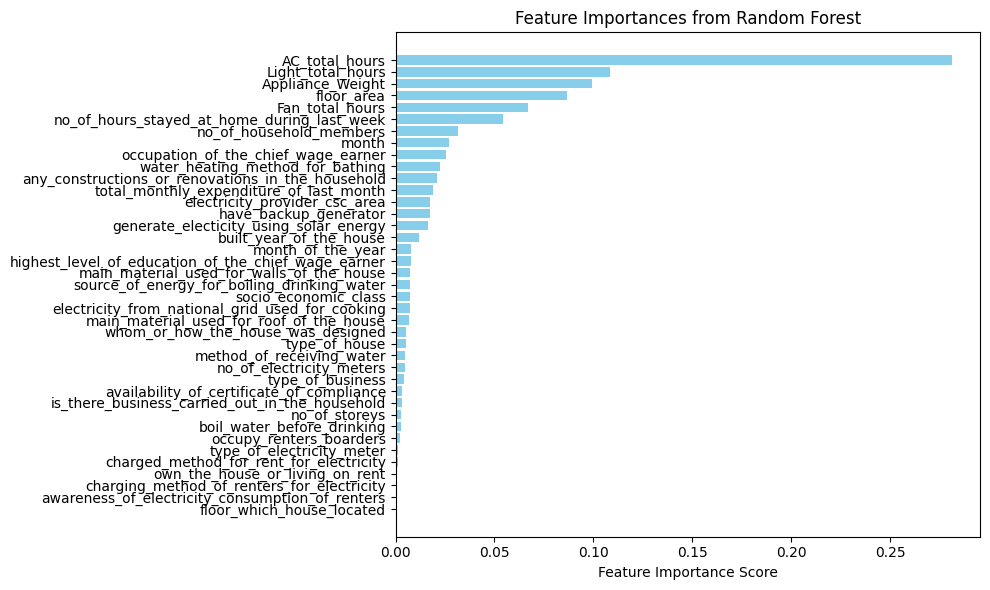

In [29]:
model = rf

importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(features[indices], importances[indices], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()